# Crop Health Prediction for Rooftop Republic (Hong Kong)

In this project, I was contracted by Rooftop Republic (https://rooftoprepublic.com/) as part of a Hackathon event to build applications that would bring added business value to their business. With the implementation of technology and improving logistical operations as their focus, I decided to build a AI model that would help them predict and identify the level of heath of their crops, which will help increase their ability to grow crops that are healthy and sustainable. 

The approach involved creating a CNN2D model that would take the image of the crop's leaf in order to determine its level of health. 

Without any dataset provided by Rooftop Republic, I had to use datasets provided on Kaggle to train the CNN2D model. The resulting prediction is a multi-class classification of one of 4 health states: Healthy, Diseased, Rust, Scab. The reason for these 4 states is that they each require a different kind of medication in order to nurse the crop back to health. For instance, the medication for Rust, will be different for a Scab. 

The result of this model was a 86% training accuracy, and a 89% validation accuracy. 

## Import Basic Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd
import os

## Prepare Image Directories

In [2]:
df = pd.read_csv("plant-pathology-2020-fgvc7/train.csv", index_col=0)
print(df.shape)
df.head()

(1821, 4)


,healthy,multiple_diseases,rust,scab
image_id,,,,
Train_0,0,0,0,1
Train_1,0,1,0,0
Train_2,1,0,0,0
Train_3,0,0,1,0
Train_4,1,0,0,0


In [3]:
#Because data files were not provided in a labeled and organized format, we need to split it and organise it in 
#files ourselves.

from sklearn.model_selection import train_test_split

train_set, valid_set = train_test_split(df, test_size=0.2, random_state=42)

print(train_set.shape)
print(valid_set.shape)

(1456, 4)
(365, 4)


In [5]:
# Create files to help organize our images

import shutil
from shutil import copyfile

os.mkdir('temp')

# train directory
os.mkdir('temp/train')
os.mkdir('temp/train/healthy')
os.mkdir('temp/train/multiple_diseases')
os.mkdir('temp/train/rust')
os.mkdir('temp/train/scab')

# validation directory
os.mkdir('temp/valid')
os.mkdir('temp/valid/healthy')
os.mkdir('temp/valid/multiple_diseases')
os.mkdir('temp/valid/rust')
os.mkdir('temp/valid/scab')

In [6]:
#Put the images in our newly created files.
#For our Training images

SOURCE = 'plant-pathology-2020-fgvc7/images/'

TRAIN_DIR = 'temp/train/'

# copy images to train directory
for index, data in train_set.iterrows():
    label = df.columns[np.argmax(data)]
    filepath = os.path.join(SOURCE, index + ".jpg")
    destination = os.path.join(TRAIN_DIR, label, index + ".jpg")
    copyfile(filepath, destination)
    
for subdir in os.listdir(TRAIN_DIR):
    print(subdir, len(os.listdir(os.path.join(TRAIN_DIR, subdir))))

multiple_diseases 73
healthy 416
rust 502
scab 465


In [7]:
#Put the images in our newly created files.
#For our Validation images

VALID_DIR = 'temp/valid/'

# copy images to valid directory
for index, data in valid_set.iterrows():
    label = df.columns[np.argmax(data)]
    filepath = os.path.join(SOURCE, index + ".jpg")
    destination = os.path.join(VALID_DIR, label, index + ".jpg")
    copyfile(filepath, destination)
    
for subdir in os.listdir(VALID_DIR):
    print(subdir, len(os.listdir(os.path.join(VALID_DIR, subdir))))
    

multiple_diseases 18
healthy 100
rust 120
scab 127


## Explore Images

In [8]:
# Take a look at our images used for training, there are 4 kings: Healthy, Scab, Rust, and Diseased

healthy_dir = os.path.join(TRAIN_DIR, 'healthy')
mdiseases_dir = os.path.join(TRAIN_DIR, 'multiple_diseases')
scab_dir = os.path.join(TRAIN_DIR, 'scab')
rust_dir = os.path.join(TRAIN_DIR, 'rust')

healthy_files = os.listdir(healthy_dir)
mdiseases_files = os.listdir(mdiseases_dir)
scab_files = os.listdir(scab_dir)
rust_files = os.listdir(rust_dir) 

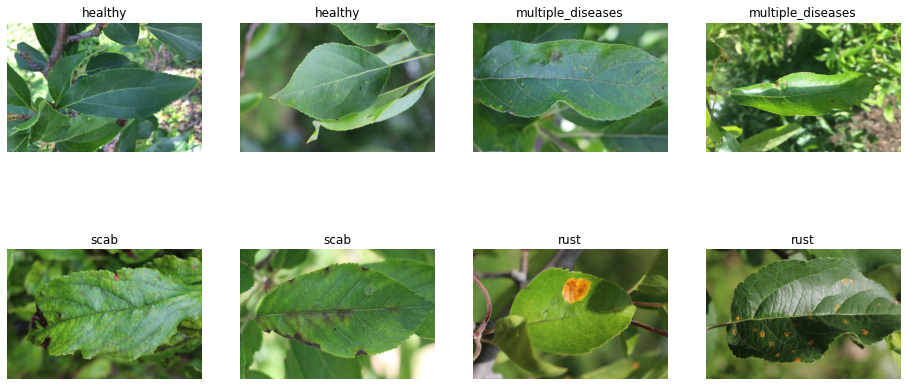

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_healthy = [os.path.join(healthy_dir, fname) for fname in healthy_files[pic_index-2:pic_index]]
next_mdiseases = [os.path.join(mdiseases_dir, fname) for fname in mdiseases_files[pic_index-2:pic_index]]
next_scab = [os.path.join(scab_dir, fname) for fname in scab_files[pic_index-2:pic_index]]
next_rust = [os.path.join(rust_dir, fname) for fname in rust_files[pic_index-2:pic_index]]


nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i, img_path in enumerate(next_healthy+next_mdiseases+next_scab+next_rust):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.title(img_path.split('/')[-2])
    plt.imshow(img)
    
plt.show()

## Keras ImageGenerator API

In [10]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(TRAIN_DIR, target_size=(150,150), class_mode='categorical', batch_size=32)
validation_generator = validation_datagen.flow_from_directory(VALID_DIR, target_size=(150,150), class_mode='categorical', batch_size=32)

Found 1456 images belonging to 4 classes.
Found 365 images belonging to 4 classes.


## Developing our CNN Model

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [12]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cnn.h5", save_best_only=True)

history = model.fit(train_generator, epochs=50, steps_per_epoch=46, 
                    validation_data = validation_generator, validation_steps=12, callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/50
46/46 [==============================] - 82s 2s/step - loss: 1.3074 - accuracy: 0.3159 - val_loss: 1.2498 - val_accuracy: 0.3479
Epoch 2/50
46/46 [==============================] - 79s 2s/step - loss: 1.2645 - accuracy: 0.3489 - val_loss: 1.2075 - val_accuracy: 0.3616
Epoch 3/50
46/46 [==============================] - 77s 2s/step - loss: 1.2683 - accuracy: 0.3880 - val_loss: 1.1954 - val_accuracy: 0.3890
Epoch 4/50
46/46 [==============================] - 78s 2s/step - loss: 1.1499 - accuracy: 0.4924 - val_loss: 1.0697 - val_accuracy: 0.5973
Epoch 5/50
46/46 [==============================] - 79s 2s/step - loss: 1.0660 - accuracy: 0.5556 - val_loss: 0.7793 - val_accuracy: 0.7315
Epoch 6/50
46/46 [==============================] - 80s 2s/step - loss: 0.8911 - accuracy: 0.6470 - val_loss: 0.6934 - val_accuracy: 0.7370
Epoch 7/50
46/46 [==============================] - 81s 2s/step - loss: 0.8040 - accuracy: 0.6848 - val_loss: 0.7225 - val_accuracy: 0.7452
Epoch 8/50
46/46 [==

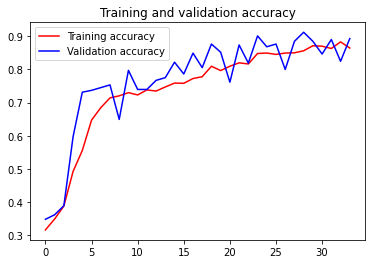

In [14]:
# Evaluating Model with test data to get scores
#Plot data to see relationship between Validation and training data

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

## Make Predictions

In [15]:
#Load our model and test with predictions!

model = tf.keras.models.load_model("cnn.h5") # rollback to best model
model.evaluate(validation_generator)


12/12 [==============================] - 13s 1s/step - loss: 0.2642 - accuracy: 0.9123


[0.2642112970352173, 0.9123287796974182]

In [16]:
#Test it out and check predictions!

from keras_preprocessing import image

test_set = pd.read_csv("plant-pathology-2020-fgvc7/test.csv", index_col=0)

X_test = []
for index, data in test_set.iterrows():
    filepath = os.path.join(SOURCE, index + ".jpg")
    img = image.load_img(filepath, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    X_test.append(x)
    
X_test = np.vstack(X_test) / 255 # rescale images

In [18]:
y_pred = model.predict(X_test, batch_size=10)
df_out = pd.concat([test_set.reset_index(), pd.DataFrame(y_pred, columns = train_generator.class_indices.keys())], axis=1).set_index("image_id")
df_out.to_csv('submission.csv')
df_out.head()

,healthy,multiple_diseases,rust,scab
image_id,,,,
Test_0,3.303821e-17,0.001631,0.998370,8.132582e-17
Test_1,1.169364e-09,0.114126,0.885874,2.794868e-08
Test_2,1.393858e-02,0.049185,0.002433,9.344434e-01
Test_3,9.384502e-01,0.006923,0.002440,5.218718e-02
Test_4,3.342652e-33,0.000025,0.999975,2.238956e-29


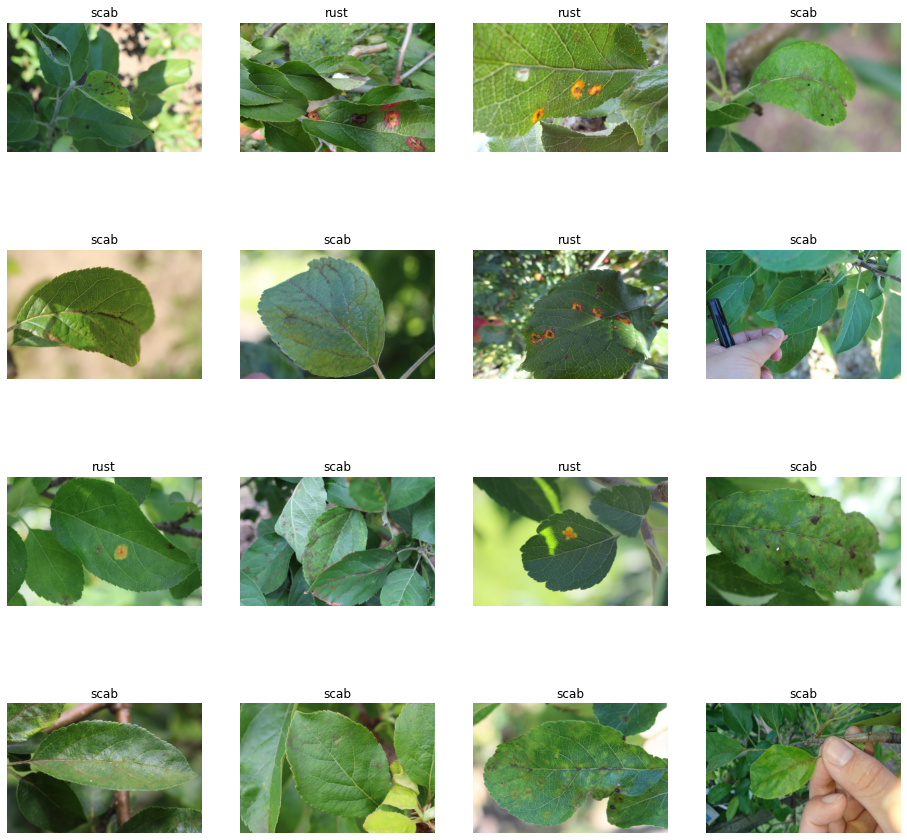

In [19]:
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i, (idx, row) in enumerate(df_out.sample(nrows*ncols).iterrows()):
    filepath = filepath = os.path.join(SOURCE, idx + ".jpg")
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(filepath)
    plt.title(df_out.columns[np.argmax(row)])
    plt.imshow(img)
    
plt.show()

## Testing with some images not part of the CNN development/validation process

Have a try yourself! Load the image of your plant's leaf into the cell below and see what the CNN predicts the level of health it is!

In [134]:
# Load the image file, resizing it to 150x150 pixels (required by this model)
img = image.load_img("/Users/nchan94/Desktop/Plant health detection/Corn_Healthy.jpg", target_size=(150, 150))
#Change the image load path to your local directory and image file name


# Convert the image to a numpy array
x = image.img_to_array(img)

# reshape the input to 4 dimensions required by the model
x =np.expand_dims(x,axis=0)

#Normalize and Rescale
x /= 255


In [135]:
prediction = model.predict({'conv2d_input': x })

if prediction[0][0]>0.5:
    print("This is a healthy crop!")
elif prediction[0][1]>0.5:
    print("This crop is sick! Please seek immediate attention!")
elif prediction[0][2]>0.5:
    print("This crop has rust! Please seek immediate attention!")
else:
    print("This crop has scabs! Please seek immediate attention!")
    
    

This is a healthy crop!


# Conclusion

Generated a good model to predict whether the plant is healthy or not based on the image of the leaf. 

What could have been done better:
- More images
- More training data
- More examples of different kinds of crops and plants leafs for better learning
- Testing with pre-trained models (e.g. Efficientnetb6)

Future Considerations:
- Cross reference to farmers and their experiences and knowledge on plant health
- Collecting database on other crops and vegeatables 
- Expand AI classfication on other known problems (e.g. Macronutrient deficiencies) 